In [26]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [53]:
class StationaryAction:
    '''
        Actions of which the expected reward (true values) do not change over time. 
    '''
    
    def __init__(self, true_mean, initial_value = 0):
        # action value = expected reward
        self.expected_mean = true_mean
        # estimate of the action value = sample-mean of rewards
        self.sample_mean = initial_value
        # number of times the action has been selected
        self.number_of_times = 0 
        
    def act(self):
        return np.random.normal(self.expected_mean,1.,1)
    
    def update_value(self, reward):
        '''
            This function computes a sample mean of rewards after an action has been performed
            i.e., recompute the sample mean given a new reward 
            The sample-average method is guaranteed to converge to the true action values 
            by the law of large number
        '''
        self.number_of_times += 1
        # the updte rule
        self.sample_mean = self.sample_mean + (reward-self.sample_mean)/float(self.number_of_times)
        
class NonstationaryAction:
    '''
        Actions of which the expected rewards (true values) change over time.
        In this case, it makes more sense to give more weight to recent rewards
        than to long-past reqards, acheived by using a constant step-size within (0,1]
        in the update rule.
    '''
    
    def __init__(self, true_mean, initial_value = 0, step_size = 0.1, random_walk_std = 0.01):
        '''
            random_walk_std is a standard devitation of a Gaussian distribution
            for modifying the true expected reward associated with each action
        '''
        # action value = expected reward
        self.expected_mean = true_mean
        # estimate of the action value = sample-mean of rewards
        self.sample_mean = initial_value
        # number of times the action has been selected
        self.number_of_times = 0 
        # a constant step-size for the update rule
        self.step_size = step_size
        self.random_walk_std = random_walk_std
        
    def copy(self, action):
        
        self.expected_mean = action.expected_mean
        self.sample_mean = action.sample_mean
        self.number_of_times = action.number_of_times
        self.step_size = action.step_size
        self.random_walk_std = action.random_walk_std
        
    def set_initial_value(self, initial_value):
        self.sample_mean = initial_value
        
    def act(self):
        return np.random.normal(self.expected_mean,self.random_walk_std,1)
    
    def nonstationary(self):
        self.expected_mean += np.random.normal(0,1.,1)
    
    def update_value(self, reward):
        '''
            This function computes a sample mean of rewards after an action has been performed
            i.e., recompute the sample mean given a new reward 
        '''
        self.number_of_times += 1
        # the updte rule
        self.sample_mean = self.sample_mean + self.step_size*(reward-self.sample_mean)

In [40]:
def stationary_bandit(action_space, max_num_step = 100, epsilon = 0.1):
    '''
        This algorithm is for actions whose assocaited true expected rewards are stationary/fixed
        The algorithm selects an action having the highest value (sample-averaged reward) most of the times,
        and with a probability of \epsilon (probability of exploration) selects an action randomly with equal probability 
        (independence of its sample-averaged reward). 
        The typical value for \epsilon is 0.05 or 0.1
    '''
    acquired_rewards = [] # acquired rewards at each time point

    for n in range(max_num_step):
        
        prob = np.random.uniform(0.,1.,1)

        # select action according to probability of exploration
        action_id = None
        # explore other actions with probability of \epsilon
        if prob <= epsilon: 
            action_id = np.random.choice(len(action_space))
        else: # pick the best action with probability 1-\epsilon
            est_mean_rewards = np.asarray([a.sample_mean for a in action_space])
            action_id = np.argmax(est_mean_rewards)
            
        selected_action = action_space[action_id]
        reward = selected_action.act()
        selected_action.update_value(reward)
        
        # collect rewards for plotting
        acquired_rewards.append(reward) 
        
    # cumulative rewards at each time point
    cumulative_rewards = np.cumsum(acquired_rewards)/(np.arange(max_num_step, dtype = np.float32)+1.0)
    
    return acquired_rewards, cumulative_rewards


def nonstationary_bandit(action_space, max_num_step = 100, epsilon = 0.1):
    '''
        This algorithm is for actions whose assocaited true expected rewards are nonstationary or vary from time step to time step
        The algorithm selects an action having the highest value (sample-averaged reward) most of the times,
        and with a probability of \epsilon (probability of exploration) selects an action randomly with equal probability 
        (independence of its sample-averaged reward). 
        The typical value for \epsilon is 0.05 or 0.1
    '''
    
    def random_walk_action_value(action_space):
        #print('Expected mean ', [a.expected_mean for a in action_space])
        for a in action_space:
            a.nonstationary()
        #print('After changes, Expected mean ', [a.expected_mean for a in action_space])
        
    acquired_rewards = [] # acquired rewards at each time point

    for n in range(max_num_step):
        
        prob = np.random.uniform(0.,1.,1)
        
        # simulate nonstationarity
        random_walk_action_value(action_space)
        
        # select action according to probability of exploration
        action_id = None
        # explore other actions with probability of \epsilon
        if prob <= epsilon: 
            action_id = np.random.choice(len(action_space))
        else: # pick the best action with probability 1-\epsilon
            est_mean_rewards = np.asarray([a.sample_mean for a in action_space])
            action_id = np.argmax(est_mean_rewards)
            
        selected_action = action_space[action_id]
        reward = selected_action.act()
        selected_action.update_value(reward)
        
        # collect rewards for plotting
        acquired_rewards.append(reward) 
        
    # cumulative rewards at each time point
    cumulative_rewards = np.cumsum(acquired_rewards)/(np.arange(max_num_step, dtype = np.float32)+1.0)
    
    return acquired_rewards, cumulative_rewards


## Stationary Action Value

In [29]:
# create a list of actions
action_space = []
for i in range(20):
    action_space.append(StationaryAction(np.random.uniform(0., 2., 1)))

print('Estimated rewards ', [a.sample_mean for a in action_space])
_, cumulative_rewards01 = stationary_bandit(action_space, 100000, 0.1)
_, cumulative_rewards005 = stationary_bandit(action_space, 100000, 0.05)
_, cumulative_rewards001 = stationary_bandit(action_space, 100000, 0.01)
_, cumulative_rewards0 = stationary_bandit(action_space, 100000, 0.) # greedy

Estimated rewards  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


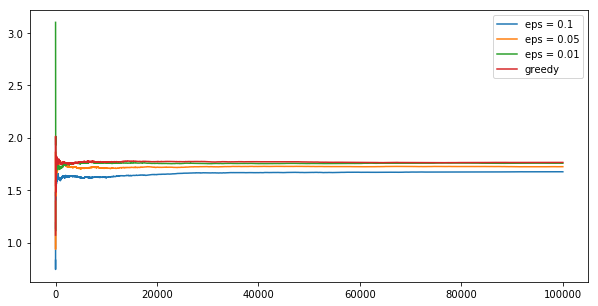

In [30]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_rewards01, label='eps = 0.1')
ax.plot(cumulative_rewards005, label='eps = 0.05')
ax.plot(cumulative_rewards001, label='eps = 0.01')
ax.plot(cumulative_rewards0, label='greedy')
plt.legend()

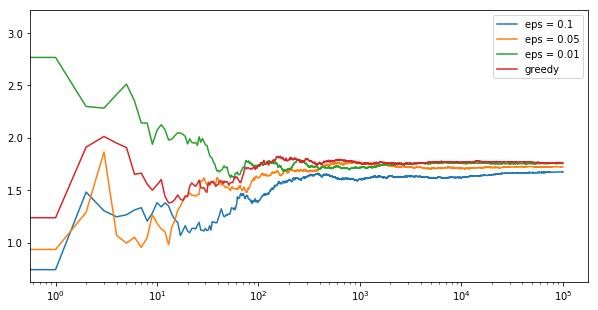

In [31]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_rewards01, label='eps = 0.1')
ax.plot(cumulative_rewards005, label='eps = 0.05')
ax.plot(cumulative_rewards001, label='eps = 0.01')
ax.plot(cumulative_rewards0, label='greedy')
plt.xscale('log')
plt.legend()

## Nonstationary

In [42]:
# create a list of actions
nonstationary_action_space = []
for i in range(20):
    nonstationary_action_space.append(NonstationaryAction(np.random.uniform(0., 2., 1)))

_, cumulative_rewards01 = nonstationary_bandit(nonstationary_action_space, 10000, 0.1)
_, cumulative_rewards005 = nonstationary_bandit(nonstationary_action_space, 10000, 0.05)
_, cumulative_rewards001 = nonstationary_bandit(nonstationary_action_space, 10000, 0.01)
_, cumulative_rewards0 = nonstationary_bandit(nonstationary_action_space, 10000, 0.) # greedy

Estimated rewards  []


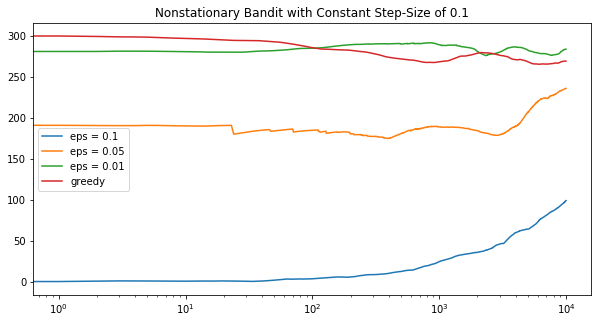

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Nonstationary Bandit with Constant Step-Size of 0.1')
ax.plot(cumulative_rewards01, label='eps = 0.1')
ax.plot(cumulative_rewards005, label='eps = 0.05')
ax.plot(cumulative_rewards001, label='eps = 0.01')
ax.plot(cumulative_rewards0, label='greedy')
plt.xscale('log')
plt.legend()

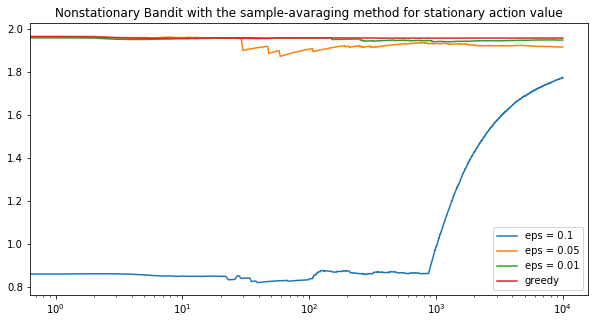

In [45]:
# create a list of actions
nonstationary_action_space = []
for i in range(20):
    nonstationary_action_space.append(NonstationaryAction(np.random.uniform(0., 2., 1)))
    
_, cumulative_rewards01 = stationary_bandit(nonstationary_action_space, 10000, 0.1)
_, cumulative_rewards005 = stationary_bandit(nonstationary_action_space, 10000, 0.05)
_, cumulative_rewards001 = stationary_bandit(nonstationary_action_space, 10000, 0.01)
_, cumulative_rewards0 = stationary_bandit(nonstationary_action_space, 10000, 0.) # greedy

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_title('Nonstationary Bandit with the sample-avaraging method for stationary action value')
ax.plot(cumulative_rewards01, label='eps = 0.1')
ax.plot(cumulative_rewards005, label='eps = 0.05')
ax.plot(cumulative_rewards001, label='eps = 0.01')
ax.plot(cumulative_rewards0, label='greedy')
plt.xscale('log')
plt.legend()

## Nonstationary Action Values with Optimistic Initial Values

In [57]:
# create a list of actions
optimistic_action_space = []
action_space = []
for i in range(20):
    action = NonstationaryAction(np.random.uniform(0., 2., 1))
    action_space.append(action)
    opt_action = NonstationaryAction(np.random.uniform(0., 2., 1))
    opt_action.copy(action)
    opt_action.set_initial_value(5)
    optimistic_action_space.append(opt_action)
    
print('Initial optimistic value ', [a.sample_mean for a in optimistic_action_space])

_, cumulative_rewards = nonstationary_bandit(action_space, 100000, 0.01)
_, opt_cumulative_rewards = nonstationary_bandit(optimistic_action_space, 100000, 0.01)


Initial optimistic value  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]


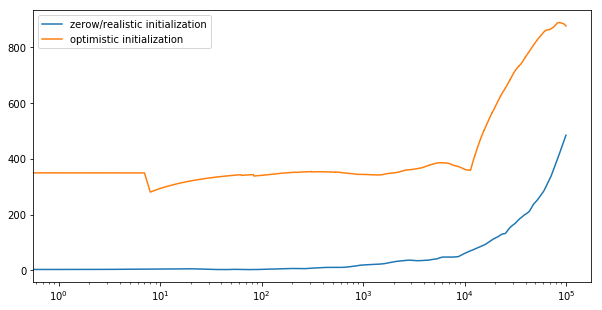

In [58]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(cumulative_rewards, label='zerow/realistic initialization')
ax.plot(opt_cumulative_rewards, label='optimistic initialization')
plt.xscale('log')
plt.legend()